## Week 6 Lab exercises

In this week we will look at ill posed and ill conditioned problems, and how to solve implicit ODEs with non linear terms.

In [48]:
# first we import the libraries we need
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# The following lines makes the plots appear inline in the notebook
%matplotlib inline

### ACTIVITY 1: 

Can we solve the non linear Van der Pol oscillator equation using implicit methods?

The Van der Pol oscillator with no source obeys the equation:

$\frac{d^2y}{dt^2} - 2a (1-y^2) \frac{dy}{dt} + y = 0$

which we can write in first order matrix form as

$\frac{d}{dt}\begin{bmatrix}
y \\
v \\
\end{bmatrix} = \begin{bmatrix}
0 & 1 \\
-1 & 2a(1-y^2)
\end{bmatrix} \begin{bmatrix}
y \\
v
\end{bmatrix}$

In the code below the equation is solved using the iterative scheme described in the lecture.

In [51]:
class VanDerPolOscillator:
    
    """Definition - a class to contain a Van Der Pol non linear
    damped oscillator.
    
       attributes: damping factor a, forcing function f_of_t, 
       lifetime of oscillations, plus private attributes for the solutions
       
       methods: to integrate the VDP equation, and produce plots of
       the solution and phase plots
    
    """
    
    # constructor function
    def __init__(self, a_damping_coeff=0.0, a_max_time = 1.0, a_N_time_steps=1000):
        self.a = a_damping_coeff
        self.max_time = a_max_time
        self.N_time_steps = a_N_time_steps
        self._delta_t = a_max_time / a_N_time_steps
        self._solution_y = np.zeros([2,a_N_time_steps+1])
        self._solution_t = np.linspace(0.0, a_max_time, a_N_time_steps+1)
        self._solution_solved = False
        
    def integrate_using_solve_ivp(self, y0) :
        solution = solve_ivp(self.calculate_VDP_dydt, [0,self.max_time],
                        y0, t_eval=self._solution_t)
        
        self._solution_y = solution.y
        self._solution_solved = True

    def integrate_using_backward_Euler(self, y0) :
        h = self._delta_t
        
        for itime, time in enumerate(self._solution_t) :
            if itime == 0 :
                self._solution_y[:,itime] = y0
            else :
                y_of_t_old   = self._solution_y[:,itime-1]
                y_of_t_old_matrix = np.matrix(y_of_t_old)
                y_of_t_guess = np.copy(y_of_t_old_matrix)
                error = 100.0
                iteration = 0
                while (error > 1.0e-6) :
                    C_matrix_t = self.get_C_matrix(y_of_t_guess)
                    I_plus_hC = np.eye(2) + h * C_matrix_t
                    I_plus_hC_inv = np.linalg.inv(I_plus_hC)
                    y_of_t_new = I_plus_hC_inv * y_of_t_old_matrix.transpose()
                    error = np.linalg.norm(y_of_t_guess - y_of_t_new)
                    y_of_t_guess = y_of_t_new
                    iteration += 1
                    
                # Now it has converged continue the time iteration
                y_of_t_new_final = y_of_t_guess.transpose()   
                self._solution_y[:,itime] = y_of_t_new_final
                
            # Mark as solved
            self._solution_solved = True
        
    def calculate_VDP_dydt(self, t, y) :
        """Returns the gradient dy/dt for the Van Der Pol equations"""
    
        y_t = y[0]
        v_t = y[1]
    
        dydt = np.zeros_like(y)
        
        # This is dydt, which is just v
        dydt[0] = v_t
        # This is dvdt, which is the VDP equation
        dydt[1] = 2.0 * self.a * (1 - y_t * y_t) * v_t - y_t
    
        return dydt
    
    def get_C_matrix(self, y_of_t) :
        
        y = float(y_of_t[0][0])
        
        # Remember that this is minus the one in the equations
        C_matrix = - 1.0 * np.matrix([[0.0, 1.0], 
                                      [-1.0, 2.0*self.a * (1.0 - y*y)]])       

        return C_matrix
    
    
    def plot_solution(self) :
        
        assert self._solution_solved, "solution has not yet been found"
        
        plt.grid()
        plt.xlabel("t", fontsize=16)
        plt.ylabel("y", fontsize=16) 
        plt.plot(self._solution_t, self._solution_y[1], 'r-', label="solve for v")
        plt.plot(self._solution_t, self._solution_y[0], 'g-', label="solve for y")
        plt.legend()
        
    def plot_phase_plot(self) :
        
        assert self._solution_solved, "solution has not yet been found"
        
        plt.grid()
        plt.xlabel("y", fontsize=16)
        plt.ylabel("v", fontsize=16) 
        plt.plot(self._solution_y[0], self._solution_y[1])       

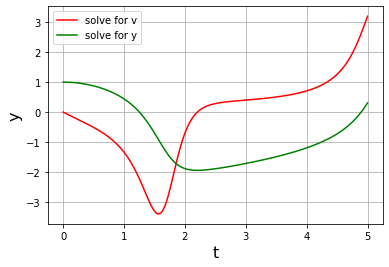

In [50]:
y0 = np.array([1.0, 0.0])
max_time = 5.0
damping = 1.0
my_oscillator = VanDerPolOscillator(damping, max_time)

# This is a useful check it is right for comparison!
#my_oscillator.integrate_using_solve_ivp(y0)

# Solve using the backward Euler method
my_oscillator.integrate_using_backward_Euler(y0)
#my_oscillator.plot_phase_plot()
my_oscillator.plot_solution()


In [ ]:
# LinearIntegrator class

class LinearIntegrator :

    """
    Contains explicit and implicit methods to integrate ODEs
    
    attributes: the function to calculate the gradient dydt, max_time, 
                N_time_steps, method
                
    methods: calculate_solution, plot_solution
    
    """
    integration_methods = ["ForwardEuler", "BackwardEuler"]
    
    # constructor function
    def __init__(self, a_C_matrix, a_max_time=0, a_N_time_steps=0, a_method = "ForwardEuler"):
        
        self.C_matrix = a_C_matrix # Note that we are passing in a function, this is ok in python
        self._method = a_method
        assert self._method in self.integration_methods, 'chosen integration method not implemented'
        
        # Make these private - restrict getting and setting as below
        self._dimension = np.size(self.C_matrix, 0)
        self._max_time = a_max_time
        self._N_time_steps = a_N_time_steps
        
        # Derived from the values above
        self._delta_t = self.max_time / self.N_time_steps
        self._t_solution = np.linspace(0.0, max_time, N_time_steps+1)
        self._y_solution = np.zeros([self.N_time_steps+1, self._dimension])

    # Enables the user to get the y solution
    @property
    def y_solution(self):
        return self._y_solution

    # Enables the user to get the t solution
    @property
    def t_solution(self):
        return self._t_solution
    
    @property
    def max_time(self):
        return self._max_time

    @property
    def N_time_steps(self):
        return self._N_time_steps

    @property
    def method(self):
        return self._method
    
    # Enables user to set the method
    @method.setter
    def method(self, value):    
        self._method = value
        assert self._method in self.integration_methods, 'chosen integration method not implemented'

    # Enables the user to reset the max time
    @max_time.setter
    def max_time(self, value):
        self._max_time = value
        self._delta_t = self.max_time / self.N_time_steps
        self._t_solution = np.linspace(0.0, self.max_time, self.N_time_steps+1)
        self._y_solution = np.zeros([self.N_time_steps+1,self._dimension])
        
    # Enables the user to reset the number of time steps
    @N_time_steps.setter
    def N_time_steps(self, value):
        self._N_time_steps = value
        self._delta_t = self.max_time / self.N_time_steps
        self._t_solution = np.linspace(0.0, self.max_time, self.N_time_steps+1)
        self._y_solution = np.zeros([self.N_time_steps+1,self._dimension])

    def calculate_solution(self, y0) :
        if (self._method == "ForwardEuler") :
            self.integrate_using_forward_Euler(y0)
        elif (self._method == "BackwardEuler") :
            self.integrate_using_backward_Euler(y0)
        else :
            assert False, 'integration method not implemented'
            
    def plot_solution(self, max_i = -1) :
        if(max_i == -1) :
            max_i = self._dimension
            
        plt.xlabel("t", fontsize=16)
        plt.ylabel("y", fontsize=16)
        for i in np.arange(max_i) :
            plt.plot(self._t_solution, self._y_solution[:,i], '-', 
                     label=self._method + " for the " + str(i) + "th variable "+ 
                             " delta_t is " + str(self._delta_t))
        plt.legend(bbox_to_anchor=(1.05, 0.5))

    def integrate_using_forward_Euler(self, y0) :
        
        h = self._delta_t
        for itime, time in enumerate(self.t_solution) :
            if itime == 0 :
                self._y_solution[itime,:] = y0
            else :
                I_matrix = np.eye(self._dimension)
                I_minus_hC = I_matrix - h * self.C_matrix
                yold = np.matrix(self._y_solution[itime-1, :])
                # Need to be a bit careful with the shapes here
                yold = yold.transpose()
                ynew = I_minus_hC * yold
                ynew = ynew.transpose()
                self._y_solution[itime,:] = ynew

    def integrate_using_backward_Euler(self, y0) :
        h = self._delta_t
        for itime, time in enumerate(self.t_solution) :
            if itime == 0 :
                self._y_solution[itime,:] = y0
            else :
                I_matrix = np.eye(self._dimension)
                I_plus_hC = I_matrix + h * self.C_matrix
                I_plus_hC_inv = np.linalg.inv(I_plus_hC) # inverse matrix
                yold = np.matrix(self._y_solution[itime-1, :])
                # Need to be a bit careful with the shapes here
                yold = yold.transpose()
                ynew = I_plus_hC_inv * yold
                ynew = ynew.transpose()
                self._y_solution[itime,:] = ynew


In [ ]:
# How to use the class - example from the lecture
C_matrix = np.matrix([[-998, -1998], [999, 1999]]) # Minus the one in the equations
y0 = np.array([1.0, 0.0])
max_time = 1.0
N_time_steps = 505 # This is the minimum for stability

# Define an object of the class
stiff_problem_integrator = LinearIntegrator(C_matrix, max_time, 
                                         N_time_steps, "ForwardEuler")

# Find and plot the solution
stiff_problem_integrator.calculate_solution(y0)
stiff_problem_integrator.plot_solution()

# Update integrator and num points to a smaller value
stiff_problem_integrator.N_time_steps = 2
stiff_problem_integrator.method = "BackwardEuler"
stiff_problem_integrator.calculate_solution(y0)
stiff_problem_integrator.plot_solution()

# Stable but still not very accurate, so increase points again
stiff_problem_integrator.N_time_steps = 100
stiff_problem_integrator.calculate_solution(y0)
stiff_problem_integrator.plot_solution()
plt.grid()

### ACTIVITY 2:
    
Now apply the integrator to the following coupled, second order harmonic oscillator system.

_HINT_ You first need to think carefully about what dimension this needs to be, and how to cast it into first order matrix form:

${\begin{aligned}
m_1{\ddot {x}}_{1}&=-kx_{1}+k(x_{2}-x_{1})=-2kx_{1}+kx_{2}
\\
m_2{\ddot {x}}_{2}&=-kx_{2}+k(x_{1}-x_{2})=-2kx_{2}+kx_{1}
\end{aligned}}$

where $k$ is the spring constant and $m_1$ and $m_2$ are the mass of the oscillators. Set the initial conditions as 

$x_1 = 1 \quad \dot{x}_1 = 0$

$x_2 = 0 \quad \dot{x}_2 = 2$

Set $k=1$ and $m_1 = 0.1$ and $m_2 = 10$

SOLUTION:

In first order form the equations are:

${\begin{aligned}
{\dot {x}}_{1} &= v_1
\\
{\dot {x}}_{2} &= v_2
\\
{\dot {v}}_{1} &= k/m_1 (-2 x_{1} + x_{2})
\\
{\dot {v}}_{2} &= k/m_2 (-2 x_{2} + x_{1})
\end{aligned}}$

So the matrix is

$\frac{d}{dt}\begin{bmatrix}
x_1 \\
x_2 \\
v_1 \\
v_2 \\
\end{bmatrix} = \begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
-2k/m_1 & k/m_1 & 0 & 0 \\
k/m_2 & -2k/m_2 & 0 & 0
\end{bmatrix} \begin{bmatrix}
x_1 \\
x_2 \\
v_1 \\
v_2 \\
\end{bmatrix}$

In [ ]:
# Integrator for the coupled harmonic oscillator

# Oscillator params
k = 1.0
m1 = 1.0
m2 = 1.0

# Remember to reverse the signs
C_matrix_oscillator = np.matrix([[0, 0, -1.0, 0], 
                                 [0, 0, 0, -1.0],
                                 [2.0*k/m1, -k/m1, 0, 0],
                                 [-k/m2, 2.0*k/m2, 0, 0]])

y0_oscillator = np.array([1.0, 0.0, 0.0, 2.0])
max_time = 10.0
N_time_steps = 1000

# Define an object of the class
stiff_problem_integrator = LinearIntegrator(C_matrix_oscillator, max_time, 
                                         N_time_steps, "ForwardEuler")

# Find and plot the solution
stiff_problem_integrator.calculate_solution(y0_oscillator)
stiff_problem_integrator.plot_solution(2)

# Update integrator and num points to a smaller value
stiff_problem_integrator.method = "BackwardEuler"
stiff_problem_integrator.calculate_solution(y0_oscillator)
stiff_problem_integrator.plot_solution(2)

# Now plot the exact solution obtained below:
max_time = 10.0
N_time_steps = 200
sqrt3 = np.sqrt(3.0)
delta_t = max_time / N_time_steps
t_solution = np.linspace(0.0, max_time, N_time_steps+1)
x1_solution = (np.sin(t_solution) - sqrt3/3.0 * np.sin(sqrt3*t_solution) +
               0.5 * np.cos(t_solution) + 0.5 * np.cos(sqrt3*t_solution))
x2_solution = (np.sin(t_solution) + sqrt3/3.0 * np.sin(sqrt3*t_solution) +
               0.5 * np.cos(t_solution) - 0.5 * np.cos(sqrt3*t_solution))

plt.plot(t_solution, x1_solution, '--', label='x1 analytic')
plt.plot(t_solution, x2_solution, '--', label='x2 analytic')
plt.legend(bbox_to_anchor=(1.05, 0.5))
plt.grid();

### ACTIVITY 3

Now we will try solving the systems with sympy. Below is the code for the lecture example. Update it to solve for the coupled harmonic oscillator above, checking against your numerical solution. Is that equation stiff or not? How can you tell?